Первоначальная версия датасета содержит 17 полей со следующей информацией:
- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [106]:
# Импортируем необходимые модули:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
from geopy.distance import geodesic
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [107]:
# Фиксируем версию пакетов для воспроизводимости экспериментов:
!pip freeze > requirements.txt

In [2]:
# Датасет для обучения:
hotels_train = pd.read_csv('.\data\hotels_train.csv.zip')

# Датасет для предсказания:
hotels_test = pd.read_csv('.\data\hotels_test.csv.zip')

# Сабмишн:
submission = pd.read_csv('.\data\submission.csv.zip')

In [3]:
# Смотрим общую информацию датасета:
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
# Смотрим статистические показатели выборки:
hotels_train.describe(include='all').round(2)

hotel_address  \
count                                              386803   
unique                                               1493   
top     163 Marsh Wall Docklands Tower Hamlets London ...   
freq                                                 3587   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        additional_number_of_scoring review_date  average_score  \
count                      386803.00      386803      386803.00   
unique                           NaN         731            NaN   
top                              NaN    8/2/2017            NaN   
freq                             NaN        1911            NaN   
mean                          498.25         NaN           8.40   
std                           500.26         NaN           0.55   
min                             1.00         NaN           5.20   
25%                           169.00         NaN           8.10   
50%                           342.00         NaN           8.40   
75%                           660.00         NaN           8.80   
max                          2682.00         NaN           9.80   

                                        hotel_name reviewer_nationality  \
count                                       386803               386803   
unique                                        1492                  225   
top     Britannia International Hotel Canary Wharf      United Kingdom    
freq                                          3587               184033   
mean                                           NaN                  NaN   
std                                            NaN                  NaN   
min                                            NaN                  NaN   
25%                                            NaN                  NaN   
50%                                            NaN                  NaN   
75%                                            NaN                  NaN   
max                                            NaN                  NaN   

       negative_review  review_total_negative_word_counts  \
count           386803                          386803.00   
unique          248828                                NaN   
top        No Negative                                NaN   
freq             95907                                NaN   
mean               NaN                              18.54   
std                NaN                              29.70   
min                NaN                               0.00   
25%                NaN                               2.00   
50%                NaN                               9.00   
75%                NaN                              23.00   
max                NaN                             408.00   

        total_number_of_reviews positive_review  \
count                 386803.00          386803   
unique                      NaN          311737   
top                         NaN     No Positive   
freq                        NaN           26885   
mean                    2743.99             NaN   
std                     2316.46             NaN   
min                       43.00             NaN   
25%                     1161.00             NaN   
50%                     2134.00             NaN   
75%                     3613.00             NaN   
max                    16670.00             NaN   

        review_total_positive_word_counts  \
count                           386803.00   
unique                                NaN   
top                                   NaN   
freq                                  NaN   
mean                              

In [5]:
# Смотрим количество дублей в данных:
hotels_train.duplicated().sum()

307

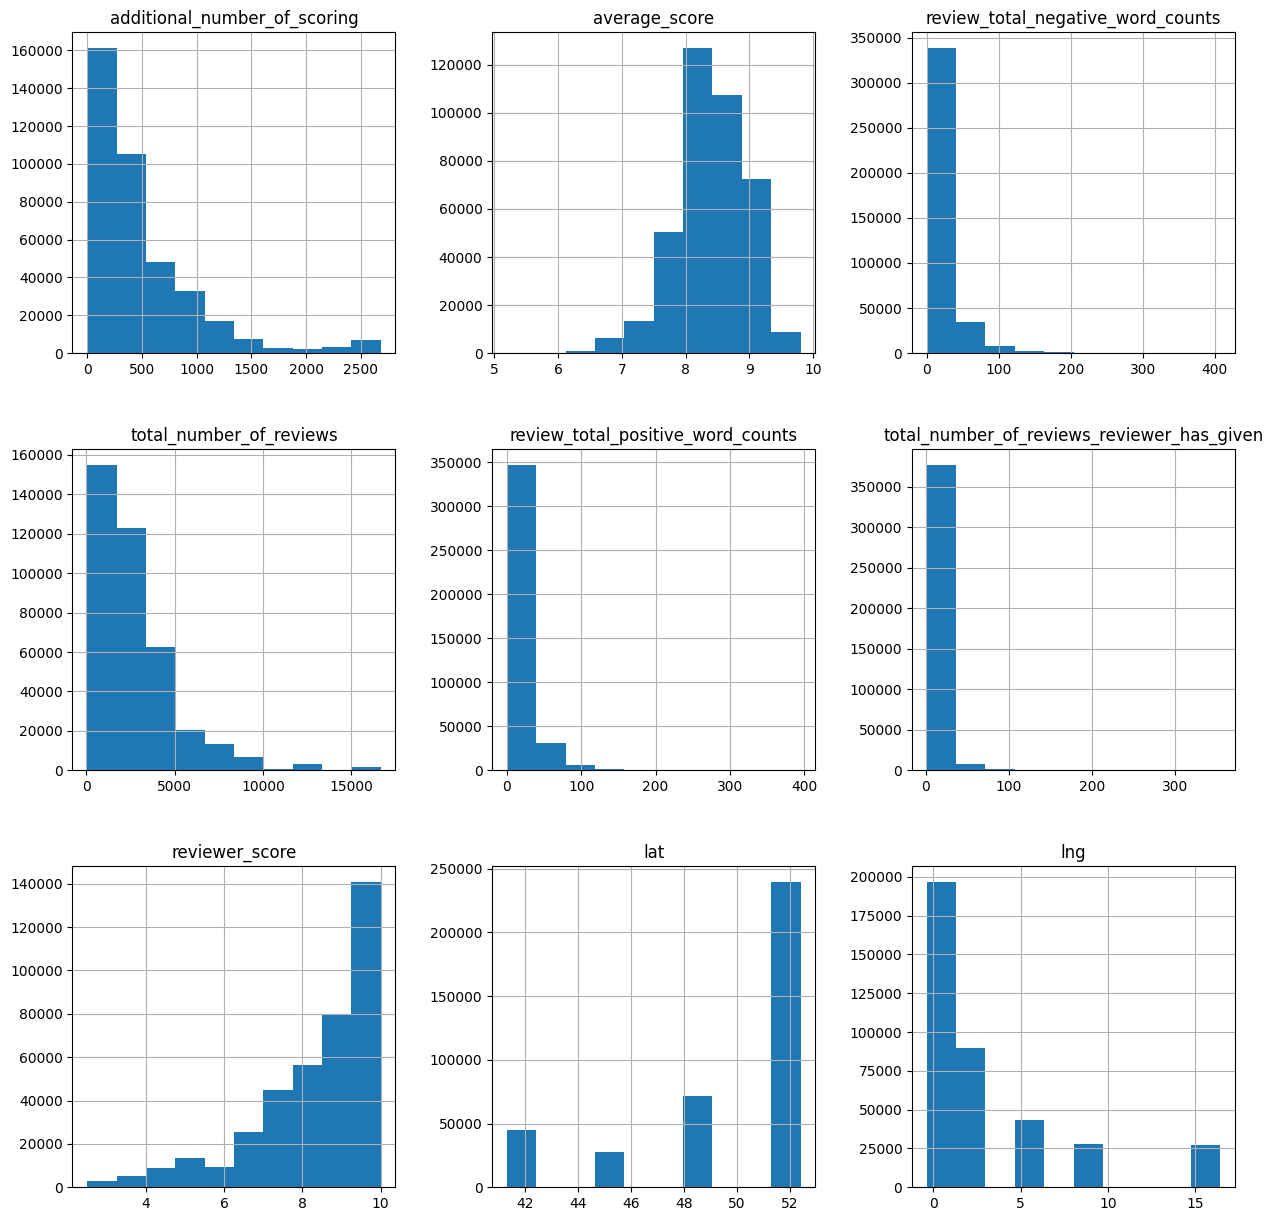

In [6]:
# Смотрим гистограммы числовых признаков:
hotels_train.hist(figsize=(15, 15));

---

In [7]:
# Смотрим общую информацию датасета:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
# Смотрим статистические показатели выборки:
hotels_test.describe(include='all').round(2)

hotel_address  \
count                                              128935   
unique                                               1493   
top     163 Marsh Wall Docklands Tower Hamlets London ...   
freq                                                 1202   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        additional_number_of_scoring review_date  average_score  \
count                      128935.00      128935      128935.00   
unique                           NaN         731            NaN   
top                              NaN    8/2/2017            NaN   
freq                             NaN         674            NaN   
mean                          497.59         NaN           8.40   
std                           501.38         NaN           0.55   
min                             1.00         NaN           5.20   
25%                           169.00         NaN           8.10   
50%                           341.00         NaN           8.40   
75%                           660.00         NaN           8.80   
max                          2682.00         NaN           9.80   

                                        hotel_name reviewer_nationality  \
count                                       128935               128935   
unique                                        1492                  202   
top     Britannia International Hotel Canary Wharf      United Kingdom    
freq                                          1202                61213   
mean                                           NaN                  NaN   
std                                            NaN                  NaN   
min                                            NaN                  NaN   
25%                                            NaN                  NaN   
50%                                            NaN                  NaN   
75%                                            NaN                  NaN   
max                                            NaN                  NaN   

       negative_review  review_total_negative_word_counts  \
count           128935                          128935.00   
unique           84673                                NaN   
top        No Negative                                NaN   
freq             31983                                NaN   
mean               NaN                              18.54   
std                NaN                              29.65   
min                NaN                               0.00   
25%                NaN                               2.00   
50%                NaN                               9.00   
75%                NaN                              23.00   
max                NaN                             402.00   

        total_number_of_reviews positive_review  \
count                 128935.00          128935   
unique                      NaN          106112   
top                         NaN     No Positive   
freq                        NaN            9061   
mean                    2743.00             NaN   
std                     2320.49             NaN   
min                       43.00             NaN   
25%                     1160.00             NaN   
50%                     2130.00             NaN   
75%                     3633.00             NaN   
max                    16670.00             NaN   

        review_total_positive_word_counts  \
count                           128935.00   
unique                                NaN   
top                                   NaN   
freq                                  NaN   
mean                              

In [9]:
# Смотрим количество дублей в данных:
hotels_test.duplicated().sum()

29

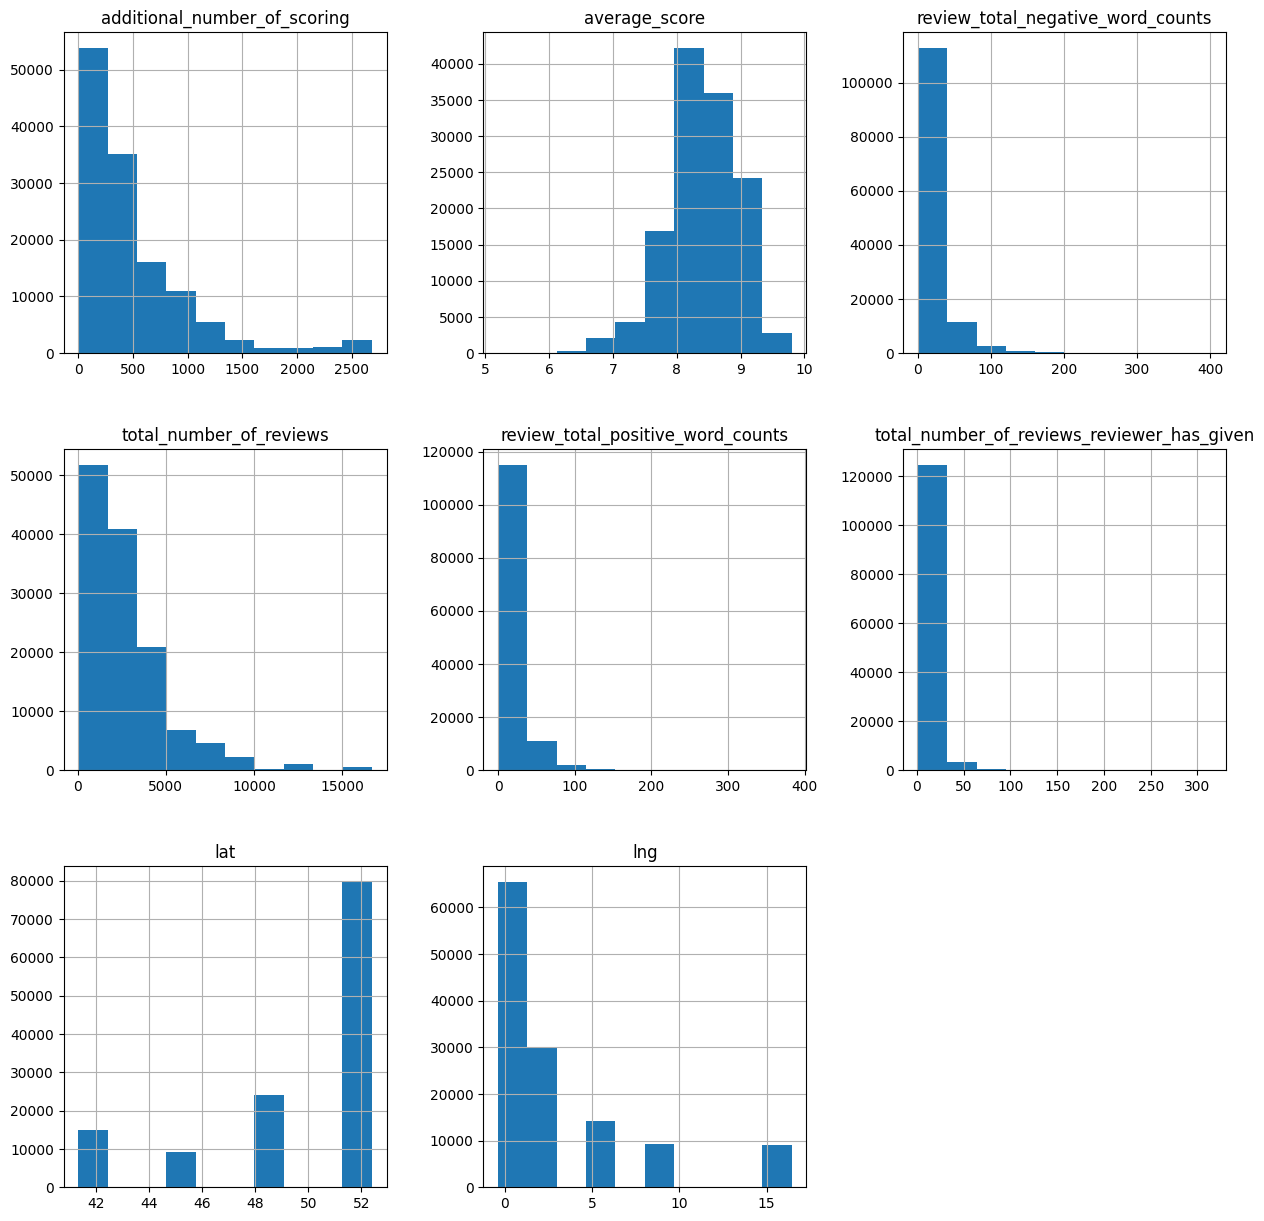

In [10]:
# Смотрим гистограммы числовых признаков:
hotels_test.hist(figsize=(15, 15));

---

In [11]:
# Смотрим общую информацию датасета:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


---
- *Судя по статистическим показателям, тренировочная и тестовая выборки схожи.*

- *В обеих выборках есть пропущенные значения в признаках координат отеля ('lat', 'lng'), которые можно заполнить в соответствии с почтовыми индексами из признака 'hotel_address'.*

- *Также в данных присутствуют дубли, которые моторые можно оставить или удалить, и посмотреть, как это влияет на ошибку предсказания.*

---
### Объединяем трейн и тест в один датасет для корректной обработки признаков:

In [12]:
# Помечаем трейн:
hotels_train['sample'] = 1

# Помечаем тест:
hotels_test['sample'] = 0

# Заполняем нулями reviewer_score (нужно предсказать) в тесте:
hotels_test['reviewer_score'] = 0 

# Объединяем трейн и тест в один датасет:
data = pd.concat([hotels_train, hotels_test])

In [13]:
# Смотрим общую информацию датасета:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
# Смотрим статистические показатели выборки:
data.describe(include='all').round(2)

hotel_address  \
count                                              515738   
unique                                               1493   
top     163 Marsh Wall Docklands Tower Hamlets London ...   
freq                                                 4789   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        additional_number_of_scoring review_date  average_score  \
count                      515738.00      515738      515738.00   
unique                           NaN         731            NaN   
top                              NaN    8/2/2017            NaN   
freq                             NaN        2585            NaN   
mean                          498.08         NaN           8.40   
std                           500.54         NaN           0.55   
min                             1.00         NaN           5.20   
25%                           169.00         NaN           8.10   
50%                           341.00         NaN           8.40   
75%                           660.00         NaN           8.80   
max                          2682.00         NaN           9.80   

                                        hotel_name reviewer_nationality  \
count                                       515738               515738   
unique                                        1492                  227   
top     Britannia International Hotel Canary Wharf      United Kingdom    
freq                                          4789               245246   
mean                                           NaN                  NaN   
std                                            NaN                  NaN   
min                                            NaN                  NaN   
25%                                            NaN                  NaN   
50%                                            NaN                  NaN   
75%                                            NaN                  NaN   
max                                            NaN                  NaN   

       negative_review  review_total_negative_word_counts  \
count           515738                          515738.00   
unique          330011                                NaN   
top        No Negative                                NaN   
freq            127890                                NaN   
mean               NaN                              18.54   
std                NaN                              29.69   
min                NaN                               0.00   
25%                NaN                               2.00   
50%                NaN                               9.00   
75%                NaN                              23.00   
max                NaN                             408.00   

        total_number_of_reviews positive_review  \
count                 515738.00          515738   
unique                      NaN          412601   
top                         NaN     No Positive   
freq                        NaN           35946   
mean                    2743.74             NaN   
std                     2317.46             NaN   
min                       43.00             NaN   
25%                     1161.00             NaN   
50%                     2134.00             NaN   
75%                     3613.00             NaN   
max                    16670.00             NaN   

        review_total_positive_word_counts  \
count                           515738.00   
unique                                NaN   
top                                   NaN   
freq                                  NaN   
mean                              

In [15]:
# Создаём признак с отметкой о наличии дублей в данных:
data['duplicates'] = data.duplicated() * 1
print(f"Количество дублей в данных: {data['duplicates'].sum()}")

Количество дублей в данных: 336


In [16]:
data.head()

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  sample  duplicates  
0  51.507894 -0.143671       1           0  
1  51.521009 -0.123097       1           0  
2  48.845377  2.325643       1           0  
3  48.888697  2.394540       1           0  
4  52.385601  4.847060       1           0

---
### Создаём отдельный датасет с информацией об отелях для удобства работы:

In [17]:
# Создаём датасет с признаками отелей:
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 
              'total_number_of_reviews', 'average_score', 
              'additional_number_of_scoring']

# Удаляем дубликаты:
hotels = data[hotel_cols].drop_duplicates().reset_index(drop=True)

# Первичный ключ id отеля = индекс:
hotels['hotel_id'] = hotels.index

In [18]:
# Добавляем к основному датасету id отеля:
data = data.merge(hotels, on=hotel_cols, how='left')

# Удаляем признаки отелей из основного датасета:
data = data.drop(hotel_cols, axis=1)

In [19]:
# Смотрим общую информацию датасета:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1477 non-null   float64
 3   lng                           1477 non-null   float64
 4   total_number_of_reviews       1494 non-null   int64  
 5   average_score                 1494 non-null   float64
 6   additional_number_of_scoring  1494 non-null   int64  
 7   hotel_id                      1494 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 93.5+ KB


In [20]:
# Смотрим статистические показатели выборки:
hotels.describe(include='all').round(2)

hotel_name                                      hotel_address  \
count           1494                                               1494   
unique          1492                                               1493   
top     Hotel Regina  8 Northumberland Avenue Westminster Borough Lo...   
freq               3                                                  2   
mean             NaN                                                NaN   
std              NaN                                                NaN   
min              NaN                                                NaN   
25%              NaN                                                NaN   
50%              NaN                                                NaN   
75%              NaN                                                NaN   
max              NaN                                                NaN   

            lat      lng  total_number_of_reviews  average_score  \
count   1477.00  1477.00                  1494.00        1494.00   
unique      NaN      NaN                      NaN            NaN   
top         NaN      NaN                      NaN            NaN   
freq        NaN      NaN                      NaN            NaN   
mean      48.34     3.97                  1297.22           8.47   
std        3.42     4.92                  1371.42           0.55   
min       41.33    -0.37                    43.00           5.20   
25%       45.53    -0.07                   422.00           8.10   
50%       48.87     2.31                   867.00           8.50   
75%       51.50     4.89                  1670.25           8.90   
max       52.40    16.43                 16670.00           9.80   

        additional_number_of_scoring  hotel_id  
count                        1494.00   1494.00  
unique                           NaN       NaN  
top                              NaN       NaN  
freq                             NaN       NaN  
mean                          190.72    746.50  
std                           245.25    431.42  
min                             1.00      0.00  
25%                            53.00    373.25  
50%                           106.00    746.50  
75%                           231.00   1119.75  
max                          2682.00   1493.00

---
### Работаем с признаком 'hotel_name':
- *В названиях отелей и адресах отелей есть пропущенные буквы из-за различия символов в алфавитах. Заменим слова с пропусками словами в английском написании.*
- *Также для удобства заменим название отеля 'May Fair' на 'Mayfair', чтобы затем создать признак сети отелей.*

In [21]:
hotels['hotel_name']

0                              The May Fair Hotel
1                 Mercure London Bloomsbury Hotel
2               Legend Saint Germain by Elegancia
3       Mercure Paris 19 Philharmonie La Villette
4                     Golden Tulip Amsterdam West
                          ...                    
1489                             Hotel Arkadenhof
1490    MARQUIS Faubourg St Honor Relais Ch teaux
1491                        Hotel Seven One Seven
1492                      Hotel Le Saint Gregoire
1493                          Hotel Gallitzinberg
Name: hotel_name, Length: 1494, dtype: object

In [22]:
# Заменим слова с пропущенными буквами:
replace_words = {
    'Ch teaux': 'Chateaux', 'Col n': 'Colon', 'Elys es': 'Elysees', 'Esther a': 'Estherea', 
    'Gr cia': 'Gracia', 'H tel': 'Hotel', 'Lam e': 'Lamee', 'M ridien': 'Meridien', 
    'May Fair': 'Mayfair', 'Op ra': 'Opera','R publique': 'Republique', 'Rosell n': 'Rosellon', 
    'V a': 'Via'
}
hotels.replace(replace_words, regex=True, inplace=True)

In [24]:
# Создаём признак принадлежности к сети отелей:
hotels['hotel_net'] = hotels['hotel_name'].apply(
    lambda x: re.search(
        r'Austria Trend|Autograph Collection|Ayre|Best Western|Club Quarters|Crowne Plaza| \
        |DoubleTree|Eurostars|Golden Tulip|Grange|H10|Hilton|Holiday Inn|Le Meridien| \
        |Luxury Collection|Marriott|Mayfair|Mercure|NH|Novotel|Park Grand|Park Plaza| \
        |Radisson|Small Luxury|The Hoxton',x
    )[0]
    if (re.search(
        r'Austria Trend|Autograph Collection|Ayre|Best Western|Club Quarters|Crowne Plaza| \
        |DoubleTree|Eurostars|Golden Tulip|Grange|H10|Hilton|Holiday Inn|Le Meridien| \
        |Luxury Collection|Marriott|Mayfair|Mercure|NH|Novotel|Park Grand|Park Plaza| \
        |Radisson|Small Luxury|The Hoxton',x
    ) is not None)
    else 'Other'
)

In [25]:
# Смотрим количество отелей в указанных сетях отелей:
hotels['hotel_net'].value_counts()

Other                   1121
Best Western              53
Mercure                   50
Hilton                    28
NH                        28
Novotel                   26
Marriott                  25
Holiday Inn               25
Radisson                  15
DoubleTree                15
Grange                    14
Austria Trend             12
H10                       11
Crowne Plaza              10
Park Plaza                 9
Luxury Collection          7
Mayfair                    7
Eurostars                  7
Park Grand                 5
Autograph Collection       5
Golden Tulip               5
Club Quarters              4
Le Meridien                4
The Hoxton                 3
Ayre                       3
Small Luxury               2
Name: hotel_net, dtype: int64

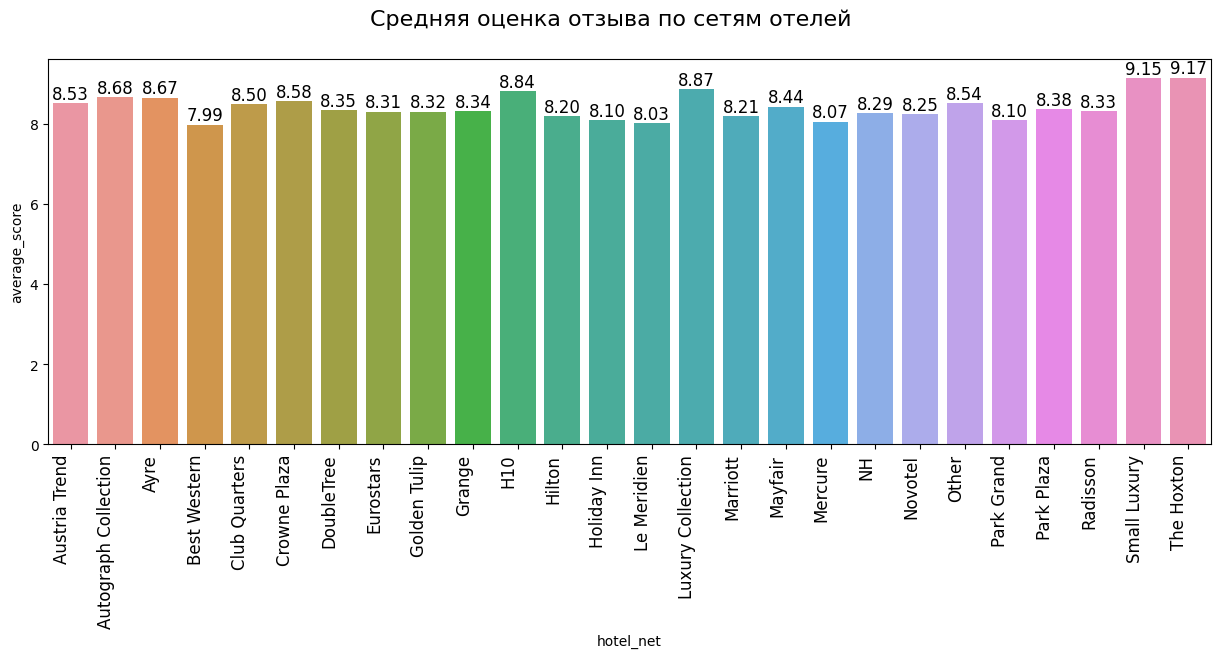

In [26]:
# Строим гистограмму распределения оценок отзывов по сетям отелей:
# Создаём сводную таблицу:
pivot_hotel_net = hotels[['hotel_net', 'average_score']].groupby('hotel_net').mean()

# Строим гистограмму:
fig0, ax0 = plt.subplots(figsize=(15, 5))
bar_hotel_net = sns.barplot(
    x=pivot_hotel_net.index, 
    y=pivot_hotel_net['average_score']
)
for p in bar_hotel_net.patches:
    bar_hotel_net.annotate('{:.2f}'.format(p.get_height()),
                           (p.get_x()+0.4, p.get_height()),
                           ha='center', 
                           va='bottom', 
                           fontsize=12)
plt.suptitle('Средняя оценка отзыва по сетям отелей', size=16)
plt.xticks(rotation=90, ha='right', fontsize=12);

- *В зависимости от сети отеля средние оценки отличаются - возможно, этот признак будет полезен при обучении модели.*

In [29]:
# Производим двоичное кодирование признака 'hotel_net', т.к. признаков > 15:
bin_encoder = ce.BinaryEncoder(cols=['hotel_net']) 
type_bin = bin_encoder.fit_transform(hotels['hotel_net'])
hotels = pd.concat([hotels, type_bin], axis=1)

---
### Работаем с признаком 'hotel_address':
- *Из адреса отеля можно выделить название страны, города и почтовый индекса.*

In [31]:
# Выделяем из адреса отеля страну, город, почтовый индекс:
# Создаём признак страны:
hotels['country'] = hotels.hotel_address.apply(
    lambda x: 'United Kingdom' 
    if x.endswith('United Kingdom') 
    else x.split()[-1]
)

# Создаём признак города:
hotels['city'] = hotels.hotel_address.apply(
    lambda x: 'London' 
    if x.endswith('United Kingdom') 
    else x.split()[-2]
)

# Создаём признак почтового индекса:
hotels['zipcode'] = hotels.hotel_address.apply(
    lambda x: x.split()[-4] + ' ' + x.split()[-3] 
    if x.endswith('United Kingdom') or x.endswith('Netherlands') 
    else x.split()[-3]
)

In [32]:
hotels['country'].value_counts()

France            458
United Kingdom    400
Spain             211
Italy             162
Austria           158
Netherlands       105
Name: country, dtype: int64

In [33]:
hotels['city'].value_counts()

Paris        458
London       400
Barcelona    211
Milan        162
Vienna       158
Amsterdam    105
Name: city, dtype: int64

- *Каждая страна представлена одним городом - оставим признак города и закодируем однократно.*

In [34]:
# Производим OHE кодирование признака 'city':
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True)
type_bin = encoder.fit_transform(hotels['city'])
hotels = pd.concat([hotels, type_bin], axis=1)

- *Зная страну и город, можно из внешних источников взять плотность населения (численность населения, площадь, и т.п.) и создать новые признаки.*

In [ ]:
# # С помощью сервиса https://www.populationpyramid.net/
# # создаём признак численности населения стран на 2017 год:
# country_population = {
#     'United Kingdom': 66064804,'Netherlands': 17207198,'France': 64144086,
#     'Spain': 46584169,'Italy': 60004032,'Austria': 8797496
# }
# hotels['country_population'] = hotels['country'].map(country_population)

In [ ]:
# # С помощью сервиса https://worldpopulationreview.com/
# # создаём признак численности населения городов на 2017 год:
# сity_population = {
#     'Paris': 10844847, 'London': 8916251, 'Milan': 3122462, 
#     'Vienna': 1878456, 'Barcelona': 5420748, 'Amsterdam': 1123080
# }
# hotels['сity_population'] = hotels['city'].map(сity_population)

In [ ]:
# # https://data.worldbank.org/ Создаём признак неравенства доходов по странам:
# # Индекс Джини за 2017 год:
# gini_index = {
#     'United Kingdom': 35.1,'Netherlands': 28.5,'France': 31.6,
#     'Spain': 34.7,'Italy': 35.9,'Austria': 29.7
# }
# hotels['gini'] = hotels['country'].map(gini_index)

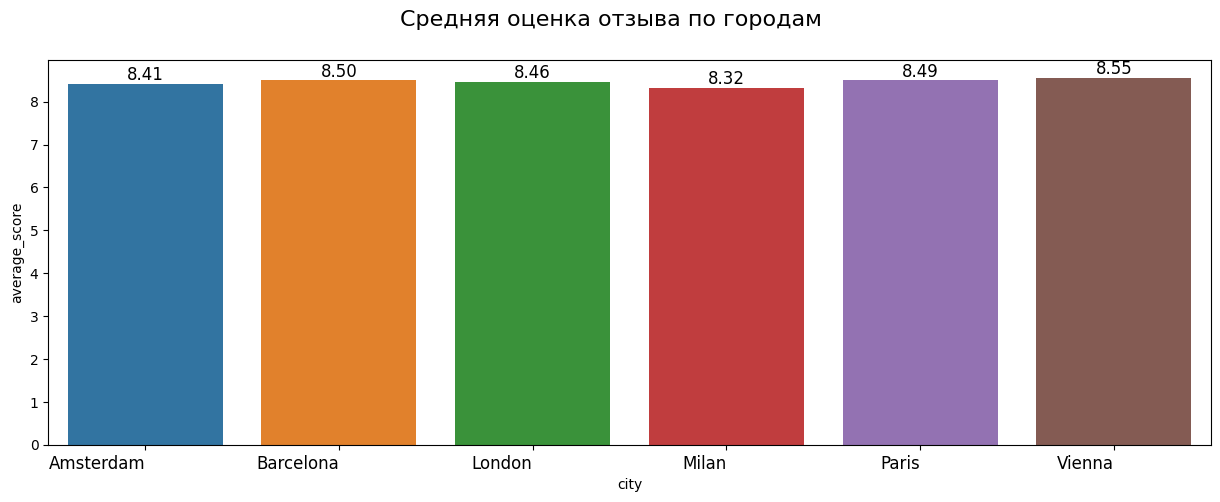

In [35]:
# Строим гистограмму распределения оценок отзывов по городам:
# Создаём сводную таблицу:
pivot_city = hotels[['city', 'average_score']].groupby('city').mean()

# Строим гистограмму:
fig1, ax1 = plt.subplots(figsize=(15, 5))
bar_city = sns.barplot(
    x=pivot_city.index, 
    y=pivot_city['average_score']
)
for p in bar_city.patches:
    bar_city.annotate('{:.2f}'.format(p.get_height()),
                           (p.get_x()+0.4, p.get_height()),
                           ha='center', 
                           va='bottom', 
                           fontsize=12)
plt.suptitle('Средняя оценка отзыва по городам', size=16)
plt.xticks(ha='right', fontsize=12);

- *Средние оценки отзывов по городам немного отличаются.*

- *Зная почтовый индекс, можно заполнить пропуски в значения координат отелей.*

In [36]:
hotels['zipcode'].value_counts()

75008       88
75009       50
1010        46
75001       41
75006       39
            ..
W2 3UY       1
W1T 5AY      1
E2 7DD       1
SW1W 8EG     1
1017 JW      1
Name: zipcode, Length: 601, dtype: int64

In [37]:
# Смотрим пропуски в координатах отелей:
hotels[hotels.lat.isna() | hotels.lng.isna()]

hotel_name  \
113   Austria Trend Hotel Schloss Wilhelminenberg Wien   
380                       Holiday Inn Paris Montmartre   
448                Fleming s Selection Hotel Wien City   
458                                      Hotel Atlanta   
600             Maison Albar Hotel Paris Opera Diamond   
613       Derag Livinghotel Kaiser Franz Joseph Vienna   
616                                 Hotel City Central   
718                     NH Collection Barcelona Podium   
757                          City Hotel Deutschmeister   
961                                Hotel Daniel Vienna   
1053                                      Roomz Vienna   
1166                Hotel Pension Baron am Schottentor   
1232                   Mercure Paris Gare Montparnasse   
1247                                  Hotel Park Villa   
1441                                     Hotel Advance   
1454                       Renaissance Barcelona Hotel   
1463                         Cordial Theaterhotel Wien   

                                          hotel_address  lat  lng  \
113    Savoyenstra e 2 16 Ottakring 1160 Vienna Austria  NaN  NaN   
380        23 Rue Damr mont 18th arr 75018 Paris France  NaN  NaN   
448   Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  NaN  NaN   
458   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  NaN  NaN   
600    4 rue de la P pini re 8th arr 75008 Paris France  NaN  NaN   
613   Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  NaN  NaN   
616   Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  NaN  NaN   
718           Bail n 4 6 Eixample 08010 Barcelona Spain  NaN  NaN   
757   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  NaN  NaN   
961   Landstra er G rtel 5 03 Landstra e 1030 Vienna...  NaN  NaN   
1053   Paragonstra e 1 11 Simmering 1110 Vienna Austria  NaN  NaN   
1166  W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  NaN  NaN   
1232      20 Rue De La Ga t 14th arr 75014 Paris France  NaN  NaN   
1247  Hasenauerstra e 12 19 D bling 1190 Vienna Austria  NaN  NaN   
1441       Sep lveda 180 Eixample 08011 Barcelona Spain  NaN  NaN   
1454      Pau Clar s 122 Eixample 08009 Barcelona Spain  NaN  NaN   
1463  Josefst dter Stra e 22 08 Josefstadt 1080 Vien...  NaN  NaN   

      total_number_of_reviews  average_score  additional_number_of_scoring  \
113                      1558            8.3                            86   
380                       298            8.3                            21   
448                      3672            8.3                           333   
458                      2724            7.8                           214   
600                      1524            8.8                           172   
613                      1496            8.0                           115   
616                      2923            8.6                           211   
718                       883            8.9                            96   
757                       675            8.0                            44   
961                      1405            8.5                           101   
1053                      568            8.1                            36   
1166                     1315            8.0                           122   
1232                      377            7.8                            22   
1247                      564            8.6                            37   
1441                      156            8.3                            18   
1454                      104            7.6                            20   
1463                      422            8.4                            39   

      hotel_id      hotel_net  hotel_net_0  ...  hotel_net_4  country  \
113        113  Austria Trend            1  ...            1  Austria   
380        380    Holiday Inn            0  ...            0   France   
448        448          Other            0  ...            1  Austria   
458        458          Other            0  ...            

In [38]:
# Заменяем пропуски на средние значения координат по почтовым индексам:
hotels['lat'].fillna(hotels['zipcode'].apply(
    lambda x: hotels[hotels['zipcode']==x]['lat'].mean()
), inplace=True)

hotels['lng'].fillna(hotels['zipcode'].apply(
    lambda x: hotels[hotels['zipcode']==x]['lng'].mean()
), inplace=True)

- *Зная координаты отелей и центров город (из внешних источников) нахождения этих отелей, можно рассчитать расстояние от отеля до центра города.*

In [40]:
# С помощью сервиса https://www.gps-latitude-longitude.com 
# получаем координаты центров городов:
cities_center = {'center_lat': {
    'London': 51.5073509, 'Paris': 48.856614,
    'Amsterdam': 52.370216, 'Milan': 45.4654219,
    'Vienna': 48.208174, 'Barcelona': 41.3850639
}, 'center_lng': {
    'London': -0.1277583, 'Paris': 2.3522219,
    'Amsterdam': 4.895168, 'Milan': 9.1859243,
    'Vienna': 16.373819, 'Barcelona': 2.1734035
}}

# Создаём признаки координат центров городов:
hotels['center_lat'] = hotels['city'].map(cities_center['center_lat'])
hotels['center_lng'] = hotels['city'].map(cities_center['center_lng'])

# Создаём признака расстояния от отеля до центра города:
hotels['dist_2_center'] = hotels.apply(lambda x: geodesic(
    (x.lat, x.lng), (x.center_lat, x.center_lng)
).kilometers, axis=1)#.round(2)

In [41]:
# Смотрим статистические показатели расстояния от отеля до центра города:
hotels['dist_2_center'].describe()

count    1494.000000
mean        2.792753
std         2.119982
min         0.070714
25%         1.341121
50%         2.328898
75%         3.781990
max        17.193441
Name: dist_2_center, dtype: float64

- *Зная почтовые индексы, с помощью сервиса https://почтовые-индексы.cybo.com/ можно обогатить данные дополнительной информацией. (На будущее улучшение)*

In [42]:
# Удаляем обработанные признаки:
hotels = hotels.drop(
    ['hotel_address','hotel_net', 'city', 'zipcode', 'center_lat','center_lng'], 
    axis=1
)

In [43]:
# Добавим обновлённую данные по отелям в основной датасет:
data = data.merge(hotels, on='hotel_id', how='left')

In [44]:
data.head()

review_date reviewer_nationality      negative_review  \
0   2/19/2016      United Kingdom              Leaving    
1   1/12/2017      United Kingdom        poor breakfast   
2  10/18/2016               China    No kettle in room    
3   9/22/2015      United Kingdom           No Negative   
4    3/5/2016              Poland          Torn sheets    

   review_total_negative_word_counts  \
0                                  3   
1                                  3   
2                                  6   
3                                  0   
4                                  4   

                                     positive_review  \
0                                 Staff were amazing   
1                                           location   
2                                        No Positive   
3   Friendly staff quiet comfortable room spotles...   
4   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  ...  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day  ...   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day  ...   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day  ...   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day  ...   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day  ...   

   hotel_net_3  hotel_net_4         country city_London  city_Paris  \
0            0            1  United Kingdom           1           0   
1            1            0  United Kingdom           1           0   
2            1            1          France           0           1   
3            1            0          France           0           1   
4            0            0     Netherlands           0           0   

   city_Amsterdam  city_Milan  city_Vienna  city_Barcelona  dist_2_center  
0               0           0            0               0       1.106434  
1               0           0            0               0       1.553596  
2               0           0            0               0       2.316565  
3               0           0            0               0       4.729362  
4               1           0            0               0       3.696425  

[5 rows x 32 columns]

---
### Работаем с признаком 'review_date':

In [45]:
# Приведём 'review_date' к формату дата/время:
data['review_date'] = pd.to_datetime(data['review_date'])

# Создаём признак года:
data['year'] = data['review_date'].dt.year

# Создаём признак месяца:
data['month'] = data['review_date'].dt.month

# Создаём признак недели:
data['week'] = data['review_date'].dt.isocalendar().week

# Создаём признак дня:
data['day'] = data['review_date'].dt.day

# Создаём признак дня недели:
data['weekday'] = data['review_date'].dt.weekday

# Создаём признак дня года:
data['dayofyear'] = data['review_date'].dt.dayofyear

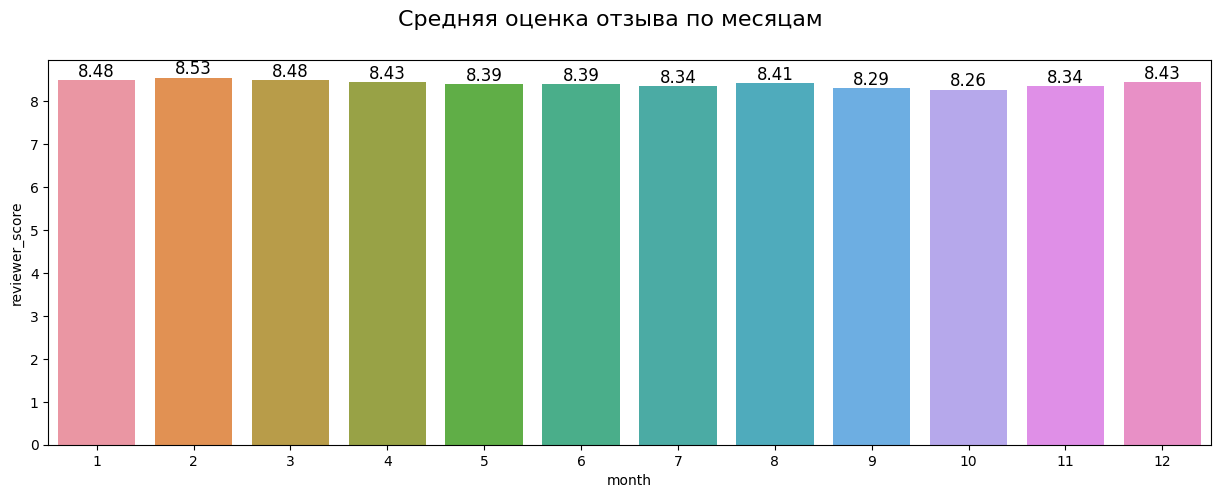

In [46]:
# Строим гистограмму распределения оценок отзывов по месяцам:
# Создаём сводную таблицу:
pivot_month = data[data['sample'] == 1][['month', 'reviewer_score']].groupby('month').mean()

# Строим гистограмму:
fig2, ax2 = plt.subplots(figsize=(15, 5))
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score']
)
for p in bar_month.patches:
    bar_month.annotate('{:.2f}'.format(p.get_height()), 
                       (p.get_x()+0.4, p.get_height()),
                       ha='center', 
                       va='bottom', 
                       fontsize=12)
plt.suptitle('Средняя оценка отзыва по месяцам', size=16);

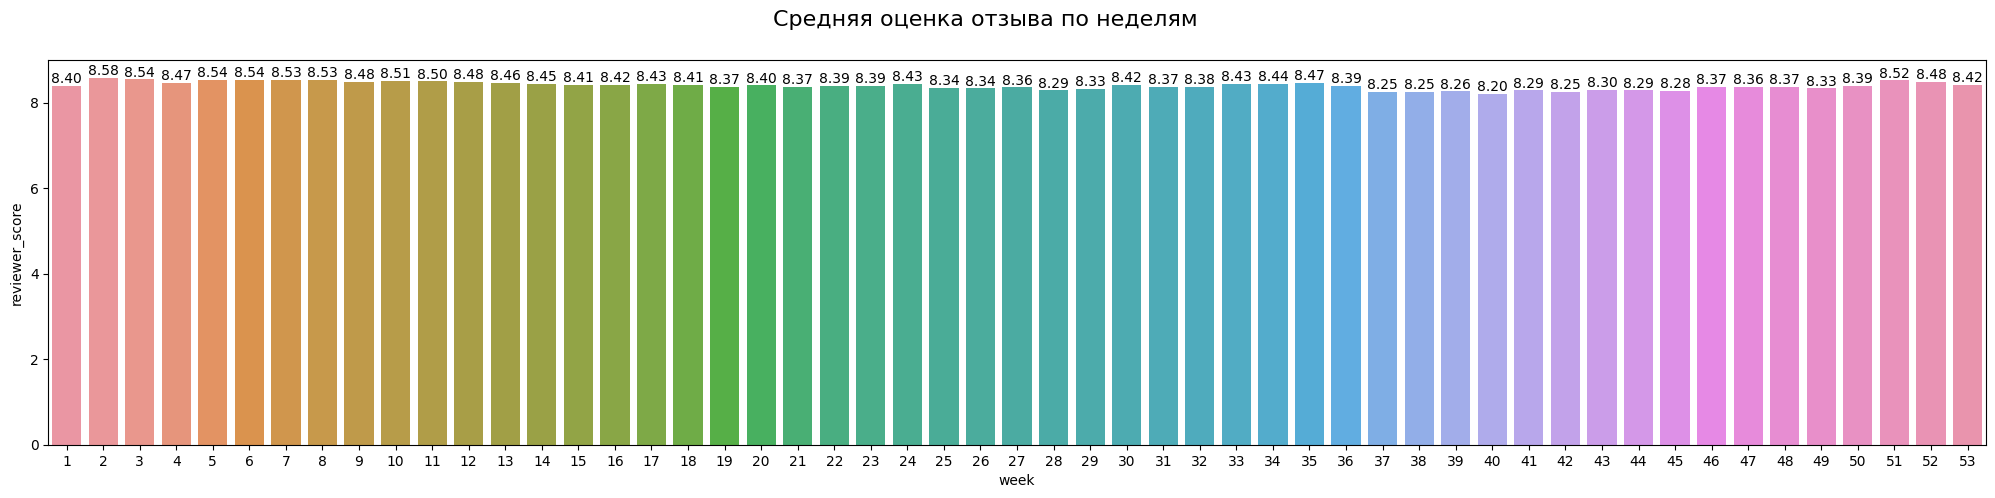

In [47]:
# Строим гистограмму распределения оценок отзывов по неделям:
# Создаём сводную таблицу:
pivot_week = data[data['sample'] == 1][['week', 'reviewer_score']].groupby('week').mean()

# Строим гистограмму:
fig3, ax3 = plt.subplots(figsize=(25, 5))
bar_week = sns.barplot(
    x=pivot_week.index, 
    y=pivot_week['reviewer_score']
)
for p in bar_week.patches:
    bar_week.annotate('{:.2f}'.format(p.get_height()), 
                       (p.get_x()+0.4, p.get_height()),
                       ha='center', 
                       va='bottom', 
                       fontsize=10)
plt.suptitle('Средняя оценка отзыва по неделям', size=16);

- *Средние оценки отзывов по месяцам и неделям самые высокие в зимний период и самые низкие в осенний период.*

---
### Работаем с признаком 'days_since_review':

In [48]:
# Приведём к числу признак 'days_since_review':
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype(int)

---
### Работаем с признаком 'reviewer_nationality'.

In [49]:
# Убираем лишние символы в значениях признака 'reviewer_nationality':
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [50]:
# Смотрим количество национальностей путешественников:
data['reviewer_nationality'].value_counts()

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Guinea                           1
Tuvalu                           1
Comoros                          1
Anguilla                         1
Cape Verde                       1
Name: reviewer_nationality, Length: 227, dtype: int64

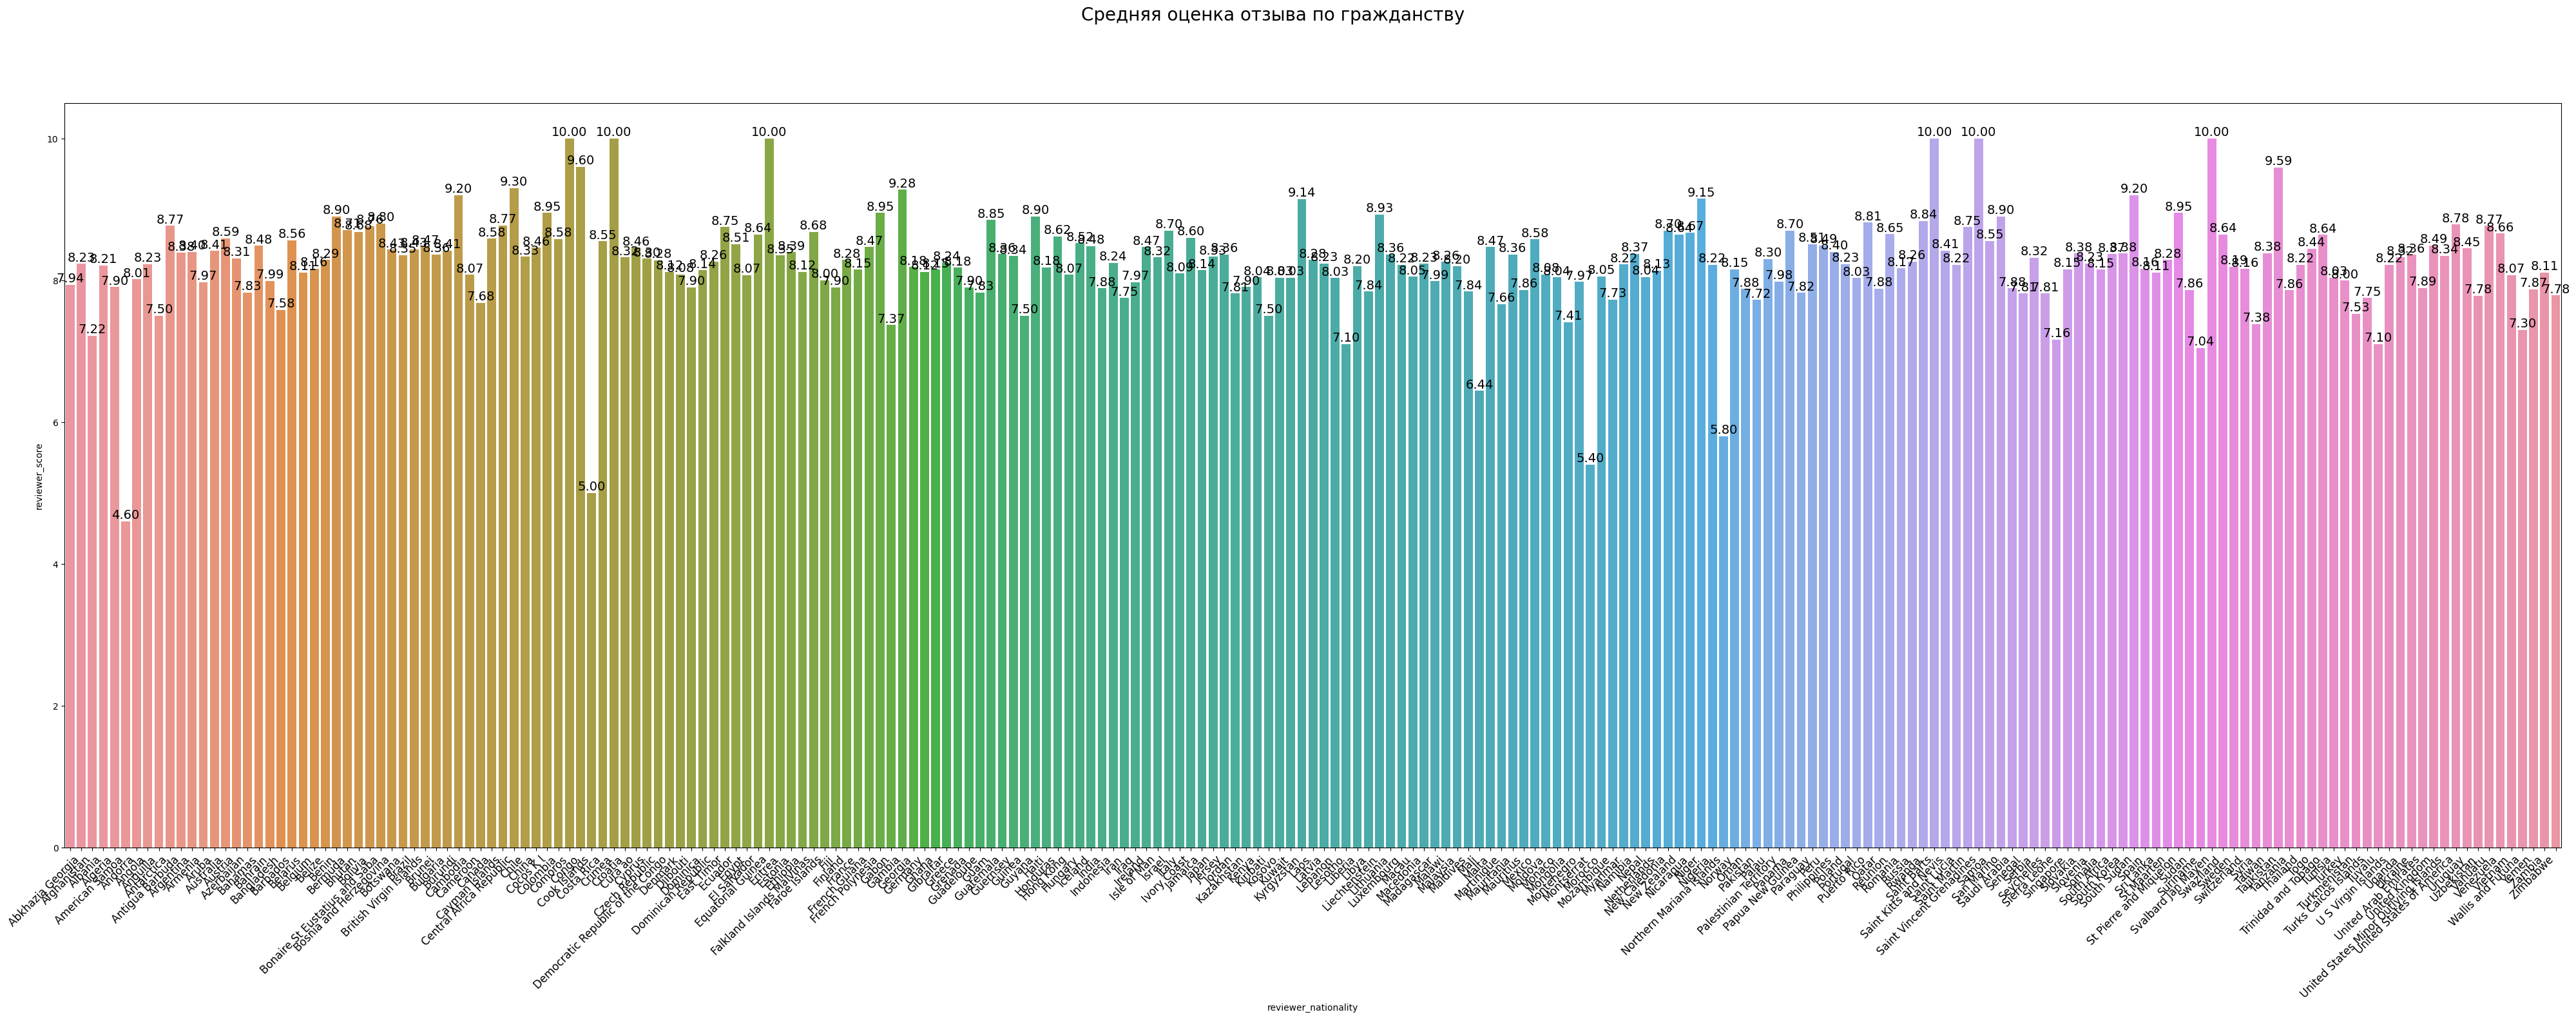

In [51]:
# Строим гистограмму распределения оценок отзывов по гражданству:
# Создаём сводную таблицу:
pivot_nationality = data[data['sample'] == 1][
    ['reviewer_nationality', 'reviewer_score']
].groupby('reviewer_nationality').mean()

# Строим гистограмму:
fig4, ax4 = plt.subplots(figsize=(50, 15))
bar_nationality = sns.barplot(
    x=pivot_nationality.index, 
    y=pivot_nationality['reviewer_score']
)
for p in bar_nationality.patches:
    bar_nationality.annotate('{:.2f}'.format(p.get_height()), 
                             (p.get_x()+0.4, p.get_height()),
                             ha='center', 
                             va='bottom', 
                             fontsize=14)
plt.suptitle('Средняя оценка отзыва по гражданству', size=20)
plt.xticks(rotation=45, ha='right', fontsize=12);

In [52]:
# Создаём признак путешественника по стране своего гражданства:
data['local'] = (data['reviewer_nationality'] == data['country']) * 1

In [53]:
# Смотрим количество путешественников по стране своего гражданства (внутренний туризм):
data['local'].mean()

0.34591788854030536

- *Примерно 35% туристов путешествуют по стране своего проживания.*

In [54]:
# Производим двоичное кодирование признака 'reviewer_nationality', т.к. признаков > 15:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

---

In [55]:
data.head()

review_date reviewer_nationality      negative_review  \
0  2016-02-19       United Kingdom             Leaving    
1  2017-01-12       United Kingdom       poor breakfast   
2  2016-10-18                China   No kettle in room    
3  2015-09-22       United Kingdom          No Negative   
4  2016-03-05               Poland         Torn sheets    

   review_total_negative_word_counts  \
0                                  3   
1                                  3   
2                                  6   
3                                  0   
4                                  4   

                                     positive_review  \
0                                 Staff were amazing   
1                                           location   
2                                        No Positive   
3   Friendly staff quiet comfortable room spotles...   
4   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags  days_since_review  ...  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...                531  ...   
1  [' Business trip ', ' Couple ', ' Standard Dou...                203  ...   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...                289  ...   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...                681  ...   
4  [' Business trip ', ' Couple ', ' Standard Dou...                516  ...   

   dayofyear  local  reviewer_nationality_0 reviewer_nationality_1  \
0         50      1                       0                      0   
1         12      1                       0                      0   
2        292      0                       0                      0   
3        265      0                       0                      0   
4         65      0                       0                      0   

   reviewer_nationality_2  reviewer_nationality_3  reviewer_nationality_4  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   

   reviewer_nationality_5  reviewer_nationality_6  reviewer_nationality_7  
0                       0                       0                       1  
1                       0                       0                       1  
2                       0                       1                       0  
3                       0                       0                       1  
4                       0                       1                       1  

[5 rows x 47 columns]

---
### Работаем с признаком 'tags':

In [56]:
# Преобразуем строковые значения признака 'tags' к списку:
data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

In [57]:
# Создаём признак количества указанных тегов:
data['tags_count'] = data['tags'].apply(lambda x: len(x))

In [58]:
# Создаём датафрейм тегов с количеством упоминаний:
tags_df = data['tags'].explode().value_counts().rename_axis('tags').reset_index(name='counts')
tags_df[:60]

tags  counts
0                          Leisure trip  417778
1        Submitted from a mobile device  307640
2                                Couple  252294
3                        Stayed 1 night  193645
4                       Stayed 2 nights  133937
5                         Solo traveler  108545
6                       Stayed 3 nights   95821
7                         Business trip   82939
8                                 Group   65392
9            Family with young children   61015
10                      Stayed 4 nights   47817
11                          Double Room   35207
12                 Standard Double Room   32248
13                 Superior Double Room   31393
14           Family with older children   26349
15                   Deluxe Double Room   24823
16                  Double or Twin Room   22393
17                      Stayed 5 nights   20845
18         Standard Double or Twin Room   17483
19                  Classic Double Room   16989
20         Superior Double or Twin Room   13570
21                              2 rooms   12393
22                      Stayed 6 nights    9776
23                   Standard Twin Room    9745
24                          Single Room    9670
25                            Twin Room    8321
26                      Stayed 7 nights    7399
27                Executive Double Room    6425
28          Classic Double or Twin Room    6107
29                   Superior Twin Room    6064
30           Deluxe Double or Twin Room    5998
31                     Club Double Room    5908
32                           Queen Room    5472
33                     Deluxe King Room    5357
34                  Superior Queen Room    4898
35                 Standard Single Room    4615
36                         Junior Suite    4559
37                          Triple Room    4493
38                        Superior Room    4417
39                         Classic Room    4416
40                   Superior King Room    4248
41                        Standard Room    4205
42                          Deluxe Room    3974
43                  Standard Queen Room    3533
44                    Double Guest Room    3437
45                   Deluxe Single Room    3283
46                    Small Double Room    3187
47                     Queen Guest Room    3125
48                     Deluxe Twin Room    3083
49                    Basic Double Room    2851
50                            King Room    2843
51                  Comfort Double Room    2641
52                  Executive King Room    2631
53                     Small Queen Room    2505
54                      Stayed 8 nights    2502
55  Standard Double Room without Window    2424
56          Comfort Double or Twin Room    2404
57       Double or Twin Room 1 2 Adults    2391
58                    Classic Twin Room    2360
59                      Twin Guest Room    2197

In [59]:
# Смотрим теги с количеством ночей:
tags_df[tags_df['tags'].apply(lambda x: 'Stayed' in x)]

tags  counts
3       Stayed 1 night  193645
4      Stayed 2 nights  133937
6      Stayed 3 nights   95821
10     Stayed 4 nights   47817
17     Stayed 5 nights   20845
22     Stayed 6 nights    9776
26     Stayed 7 nights    7399
54     Stayed 8 nights    2502
75     Stayed 9 nights    1293
97    Stayed 10 nights     889
134   Stayed 11 nights     418
159   Stayed 12 nights     316
198   Stayed 14 nights     247
200   Stayed 13 nights     246
345   Stayed 15 nights     117
588   Stayed 16 nights      57
735   Stayed 17 nights      42
827   Stayed 18 nights      33
889   Stayed 19 nights      29
1000  Stayed 21 nights      23
1107  Stayed 20 nights      19
1366  Stayed 30 nights      11
1398  Stayed 27 nights      11
1423  Stayed 22 nights      10
1428  Stayed 23 nights      10
1639  Stayed 25 nights       7
1648  Stayed 26 nights       7
1650  Stayed 28 nights       7
1683  Stayed 24 nights       6
1769  Stayed 29 nights       5
2262  Stayed 31 nights       1

In [60]:
# Создаём признак количества ночей:
data['stayed_nights'] = data['tags'].apply(
    lambda x:
    1 if 'Stayed 1 night' in x else
    2 if 'Stayed 2 nights' in x else
    3 if 'Stayed 3 nights' in x else
    4 if 'Stayed 4 nights' in x else
    5 if 'Stayed 5 nights' in x else
    6 if 'Stayed 6 nights' in x else
    7 if 'Stayed 7 nights' in x else
    8 if 'Stayed 8 nights' in x else
    9 if 'Stayed 9 nights' in x else
    10 if 'Stayed 10 nights' in x else
    11 if 'Stayed 11 nights' in x else
    12 if 'Stayed 12 nights' in x else
    13 if 'Stayed 13 nights' in x else
    14 if 'Stayed 14 nights' in x else
    15 if 'Stayed 15 nights' in x else
    16 if 'Stayed 16 nights' in x else
    17 if 'Stayed 17 nights' in x else
    18 if 'Stayed 18 nights' in x else
    19 if 'Stayed 19 nights' in x else
    20 if 'Stayed 20 nights' in x else
    21 if 'Stayed 21 nights' in x else
    22 if 'Stayed 22 nights' in x else
    23 if 'Stayed 23 nights' in x else
    24 if 'Stayed 24 nights' in x else
    25 if 'Stayed 25 nights' in x else
    26 if 'Stayed 26 nights' in x else
    27 if 'Stayed 27 nights' in x else
    28 if 'Stayed 28 nights' in x else
    29 if 'Stayed 29 nights' in x else
    30 if 'Stayed 30 nights' in x else
    31 if 'Stayed 31 nights' in x else 0
)

In [61]:
data['stayed_nights'].value_counts()

1     193645
2     133937
3      95821
4      47817
5      20845
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
30        11
27        11
22        10
23        10
28         7
26         7
25         7
24         6
29         5
31         1
Name: stayed_nights, dtype: int64

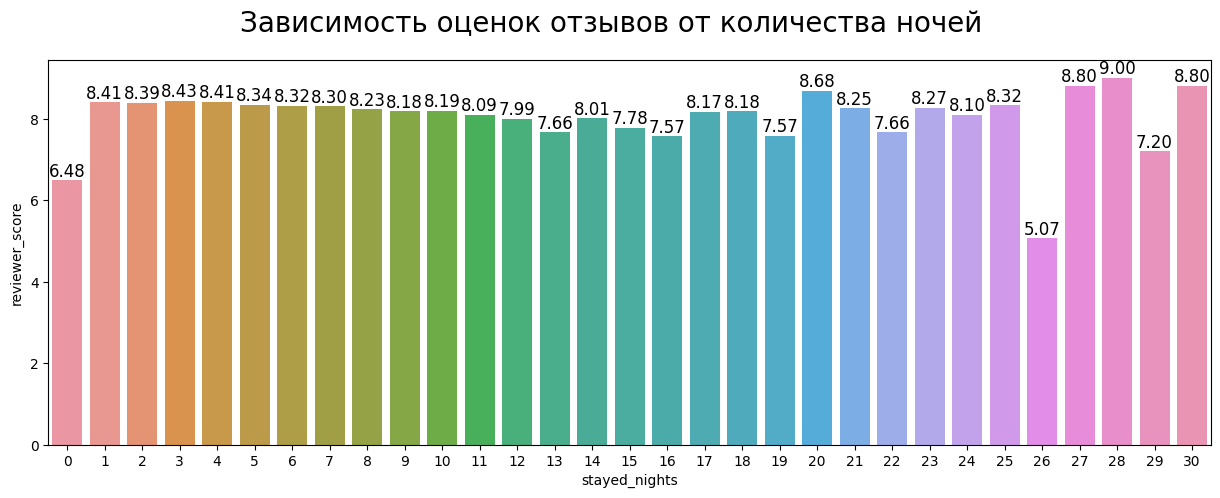

In [62]:
# Строим гистограмму зависимости оценок отзывов от количества ночей:
# Создаём сводную таблицу:
pivot_stayed_nights = data[data['sample'] == 1][
    ['stayed_nights', 'reviewer_score']
].groupby('stayed_nights').mean()

# Строим гистограмму:
fig5, ax5 = plt.subplots(figsize=(15, 5))
bar_stayed_nights = sns.barplot(
    x=pivot_stayed_nights.index, 
    y=pivot_stayed_nights['reviewer_score']
)
for p in bar_stayed_nights.patches:
    bar_stayed_nights.annotate('{:.2f}'.format(p.get_height()), 
                               (p.get_x()+0.4, p.get_height()),
                               ha='center', 
                               va='bottom', 
                               fontsize=12)
plt.suptitle('Зависимость оценок отзывов от количества ночей', size=20);

---

In [63]:
# Создаём признак цели поездки:
data['trip'] = data['tags'].apply(
    lambda x: 
    1 if 'Leisure trip' in x else
    2 if 'Business trip' in x else 0
)

---

In [64]:
# Создаём признак устройства отправки отзыва:
data['mobile_submit'] = data['tags'].apply(
    lambda x:
    1 if 'Submitted from a mobile device' in x else 0
)

---

In [65]:
# Создаём признак количества путешественников:
data['people_count'] = data['tags'].apply(
    lambda x: 
    1 if 'Solo traveler' in x else
    2 if 'Couple' in x else
    3 if 'Group' in x else
    4 if 'Family with young children' in x else
    5 if 'Family with older children' in x else
    6 if 'Travelers with friends' in x else 0
)

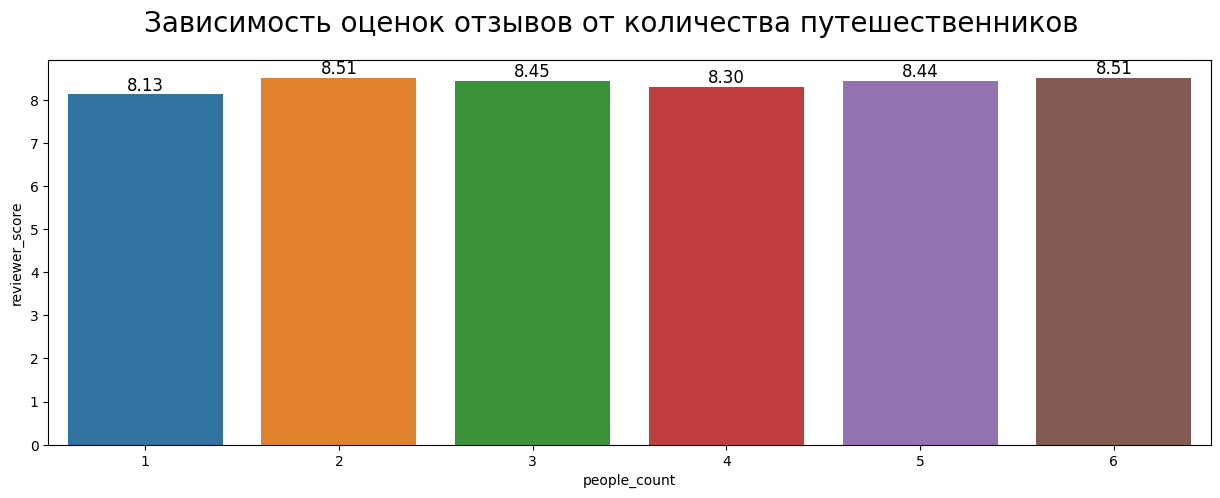

In [66]:
# Строим гистограмму зависимости оценок отзывов от количества путешественников:
# Создаём сводную таблицу:
pivot_people_count = data[data['sample'] == 1][
    ['people_count', 'reviewer_score']
].groupby('people_count').mean()

# Строим гистограмму:
fig6, ax6 = plt.subplots(figsize=(15, 5))
bar_people_count = sns.barplot(
    x=pivot_people_count.index, 
    y=pivot_people_count['reviewer_score']
)
for p in bar_people_count.patches:
    bar_people_count.annotate('{:.2f}'.format(p.get_height()), 
                               (p.get_x()+0.4, p.get_height()),
                               ha='center', 
                               va='bottom', 
                               fontsize=12)
plt.suptitle('Зависимость оценок отзывов от количества путешественников', size=20);

- *Самые низкие оценки ставят одиночные путешественники, самые высокие оценки ставят путешественники в паре или с друзьями.*

---

In [67]:
# Создаём признак путешествия с питомцем:
data['pet'] = data['tags'].apply(
    lambda x: 1 if 'With a pet' in x else 0
)

---
### Работаем с признаками количества позитивных и негативных слов в отзыве:

In [68]:
# Создаём признак разницы позитивных и негативных слов в отзыве:
data['review_total_word_counts'] = data['review_total_positive_word_counts'] \
- data['review_total_negative_word_counts']

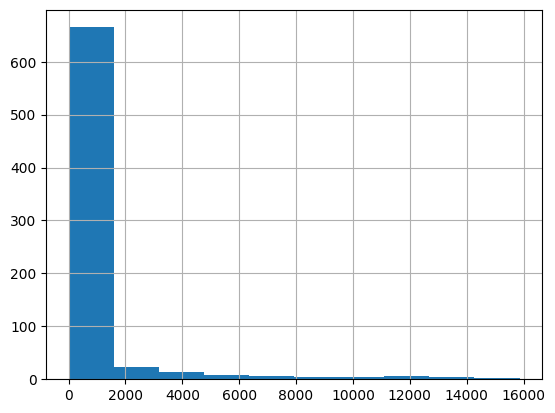

In [69]:
data['review_total_word_counts'].value_counts().hist();

In [70]:
# Создаём признак позитивного, нейтрального или негативного окраса отзыва:
data['review_total_color'] = data['review_total_word_counts'].apply(
    lambda x: 1 if x > 0 else -1 if x < 0 else 0    
)

---
### Работаем с признаком позитивного и негативного отзыва:

In [71]:
# Очищаем от лишних символов и смотрим частоту встречающихся отзывов:
data['negative_review'].str.lower().str.strip().value_counts()[:60]

no negative                        127890
nothing                             21185
n a                                  1815
none                                 1501
                                      849
nothing really                        656
small room                            570
all good                              545
breakfast                             545
no complaints                         523
location                              502
nothing at all                        467
everything                            420
nothing to dislike                    373
price                                 348
nil                                   332
small rooms                           307
everything was perfect                276
na                                    272
can t think of anything               250
leaving                               244
absolutely nothing                    242
everything was great                  222
expensive                         

- *В отрицательном отзыве есть фразы 'no negative', 'nothing' и другие, которые обозначают отсутствие негатива.*

In [72]:
# Создаём признаки отсутствия негатива в негативном отзыве и позитива - в позитивном:
data['no_neg'] = 0
data['no_pos'] = 0

# Список не негативных фраз в негативном отзыве:
no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 
               'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 
               'liked everything', 'can t think of anything', 'everything was perfect', 
               'no', 'absolutely nothing', 'having to leave', 'everything was great', 
               'nothing to complain about', 'non']

# Заполняем признаки:
data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1

# Убираем не негативную фразу из негативного отзыва:
data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

In [73]:
# Очищаем от лишних символов и смотрим частоту встречающихся отзывов:
data['positive_review'].str.lower().str.strip().value_counts()[:60]

no positive                        35946
location                           11945
everything                          3314
nothing                             1731
great location                      1687
the location                        1606
good location                       1496
breakfast                            795
friendly staff                       733
excellent location                   639
staff                                553
location and staff                   452
location staff                       432
location location location           345
location was great                   328
everything was perfect               316
good breakfast                       316
location was good                    312
comfy bed                            303
perfect location                     287
the staff                            281
location is great                    280
location is good                     256
all                                  250
clean           

- *В положитльном отзыве есть фразы 'no positive', 'nothing', 'not much', которые обозначают отсутствие позитива.*

In [74]:
# Список не позитивных фраз в позитивном отзыве:
no_pos_list = ['no positive', 'nothing', 'not much']

# Заполняем признаки:
data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
data.loc[data['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

# Убираем не позитивную фразу из позитивного отзыва:
data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'positive_review'] = ''

In [75]:
# Создаём признаки длины позитивных и негативных отзывов:
data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)

---
### Работаем с пакетом символьной и статистической обработки естественного языка для анализа отзывов:

In [77]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [78]:
# Создаём экземпляр класса:
sent_analyzer = SentimentIntensityAnalyzer()

# Анализируем отзывы:
data['sia_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['sia_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# Записываем результаты в основной датафрейм в виде отдельных признаков:
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['sia_neg'].apply(
    lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]
).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['sia_pos'].apply(
    lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]
).values)

In [79]:
# Создаём признак доли позитивных слов среди всех слов отзыва:
data['pos_words_ratio'] = data['review_total_positive_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])

# Создаём признак доли негативных слов среди всех слов отзыва:
data['neg_words_ratio'] = data['review_total_negative_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])

In [80]:
# Создаём признак среднего количества позитивных слов в отзыве туриста:
data['pos_words_per_review'] = data['review_total_positive_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']

# Создаём признак среднего количества негативных слов в отзыве туриста:
data['neg_words_per_review'] = data['review_total_negative_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']

---

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   reviewer_nationality                        515738 non-null  object        
 2   negative_review                             515738 non-null  object        
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   positive_review                             515738 non-null  object        
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   reviewer_score                              515738 non-null  float64       
 8   tags                                        515738 non-null  object       

In [82]:
# Удаляем признаки строкового типа:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

In [83]:
# Заполняем нулями пропуски:
data = data.fillna(0)

---
### Оценим значимость категориальных переменных с помощью непараметрического теста хи-квадрат:

In [86]:
# Категориальные признаки:
cat_cols = [
    'duplicates', 'hotel_id', 'lat', 'lng', 'average_score', 'additional_number_of_scoring',
    'hotel_net_0', 'hotel_net_1','hotel_net_2','hotel_net_3','hotel_net_4',
    'city_London', 'city_Paris', 'city_Amsterdam', 'city_Milan', 'city_Vienna', 
    'city_Barcelona', 'year', 'month', 'week', 'day', 'weekday', 'dayofyear', 'local',
    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 
    'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4',
    'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7',
    'stayed_nights', 'trip', 'people_count', 'pet', 
    'no_neg', 'no_pos'
]    

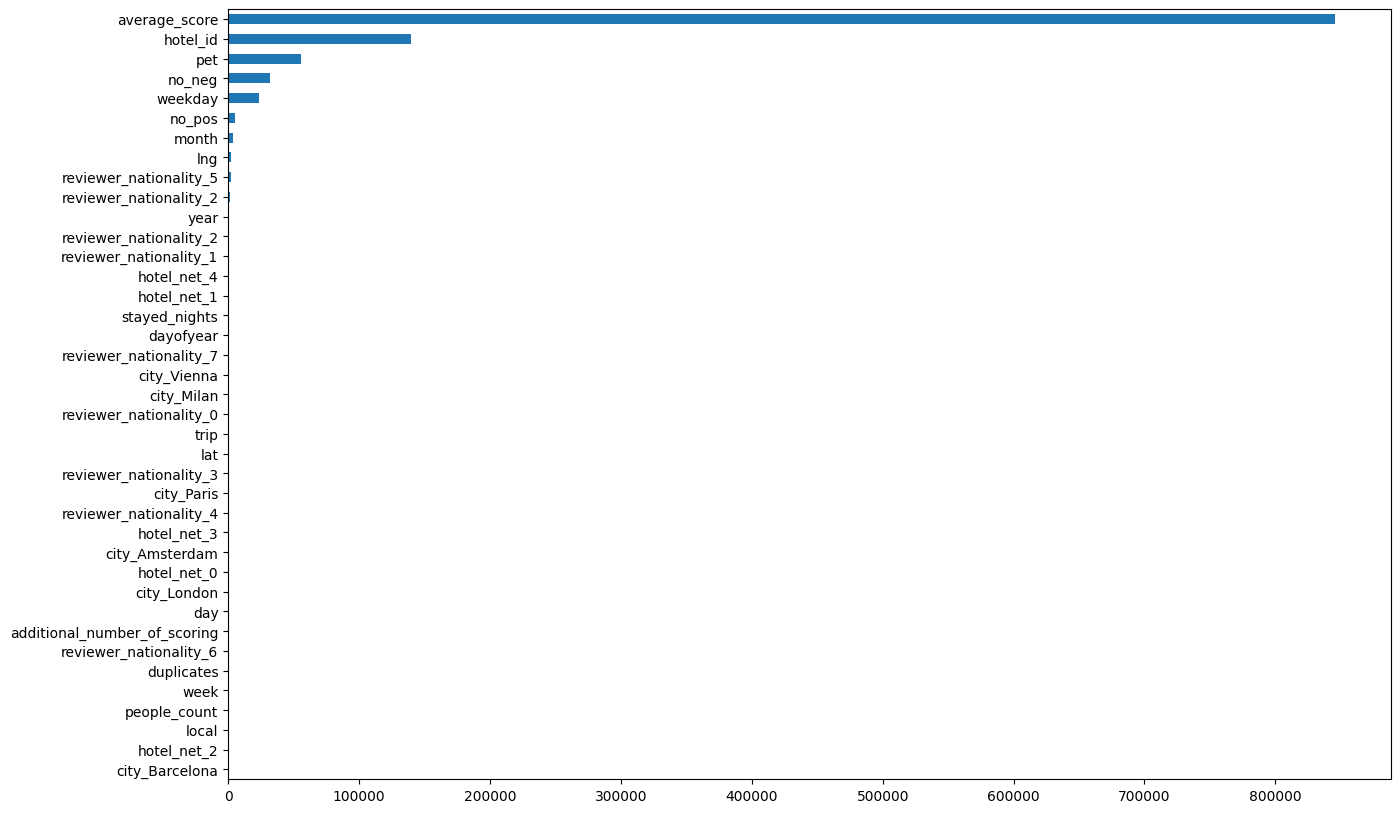

In [87]:
# Выведем значения хи-квадрат на графике:
y = data.query('sample == 1').drop(
    ['sample'], axis=1
).reviewer_score.values.astype(int)
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

---
### Оценим значимость непрерывных переменных с помощью f_classif из библиотеки sklearn.
*В основе метода оценки значимости переменных лежит анализ (ANOVA).*

*В качестве меры значимости будем использовать значение f-статистики: чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.*

In [90]:
# Непрерывные признаки:
num_cols = [
    'total_number_of_reviews', 'review_total_negative_word_counts', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given',
    'additional_number_of_scoring', 'days_since_review','dist_2_center', 
    'tags_count', 
    'review_total_word_counts', 'pos_len', 'neg_len', 'n_neg', 'n_neu', 
    'n_pos',     'n_compound',
    'p_neg', 'p_neu', 'p_pos', 'p_compound', 'pos_words_ratio', 
    'neg_words_ratio',
    'pos_words_per_review', 'neg_words_per_review'
]

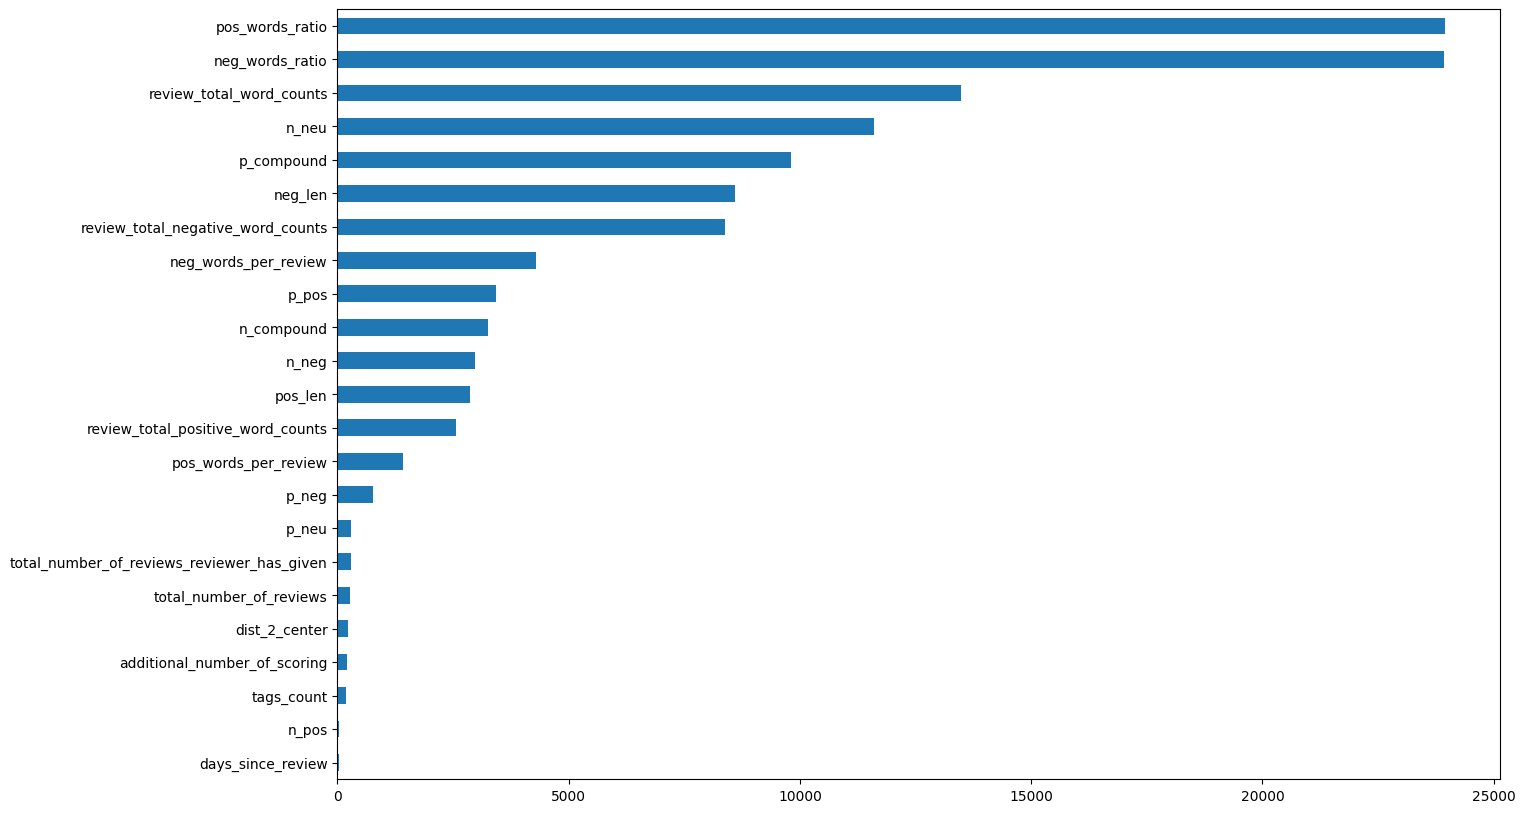

In [91]:
# Выведем значения теста ANOVA на графике:
y = data.query('sample == 1').drop(
    ['sample'], axis=1
).reviewer_score.values.astype(int)
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

---
### Построим матрицу корреляции и затем удалим лишние признаки:

C:\Users\user\AppData\Local\Temp\ipykernel_6588\464063375.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True);


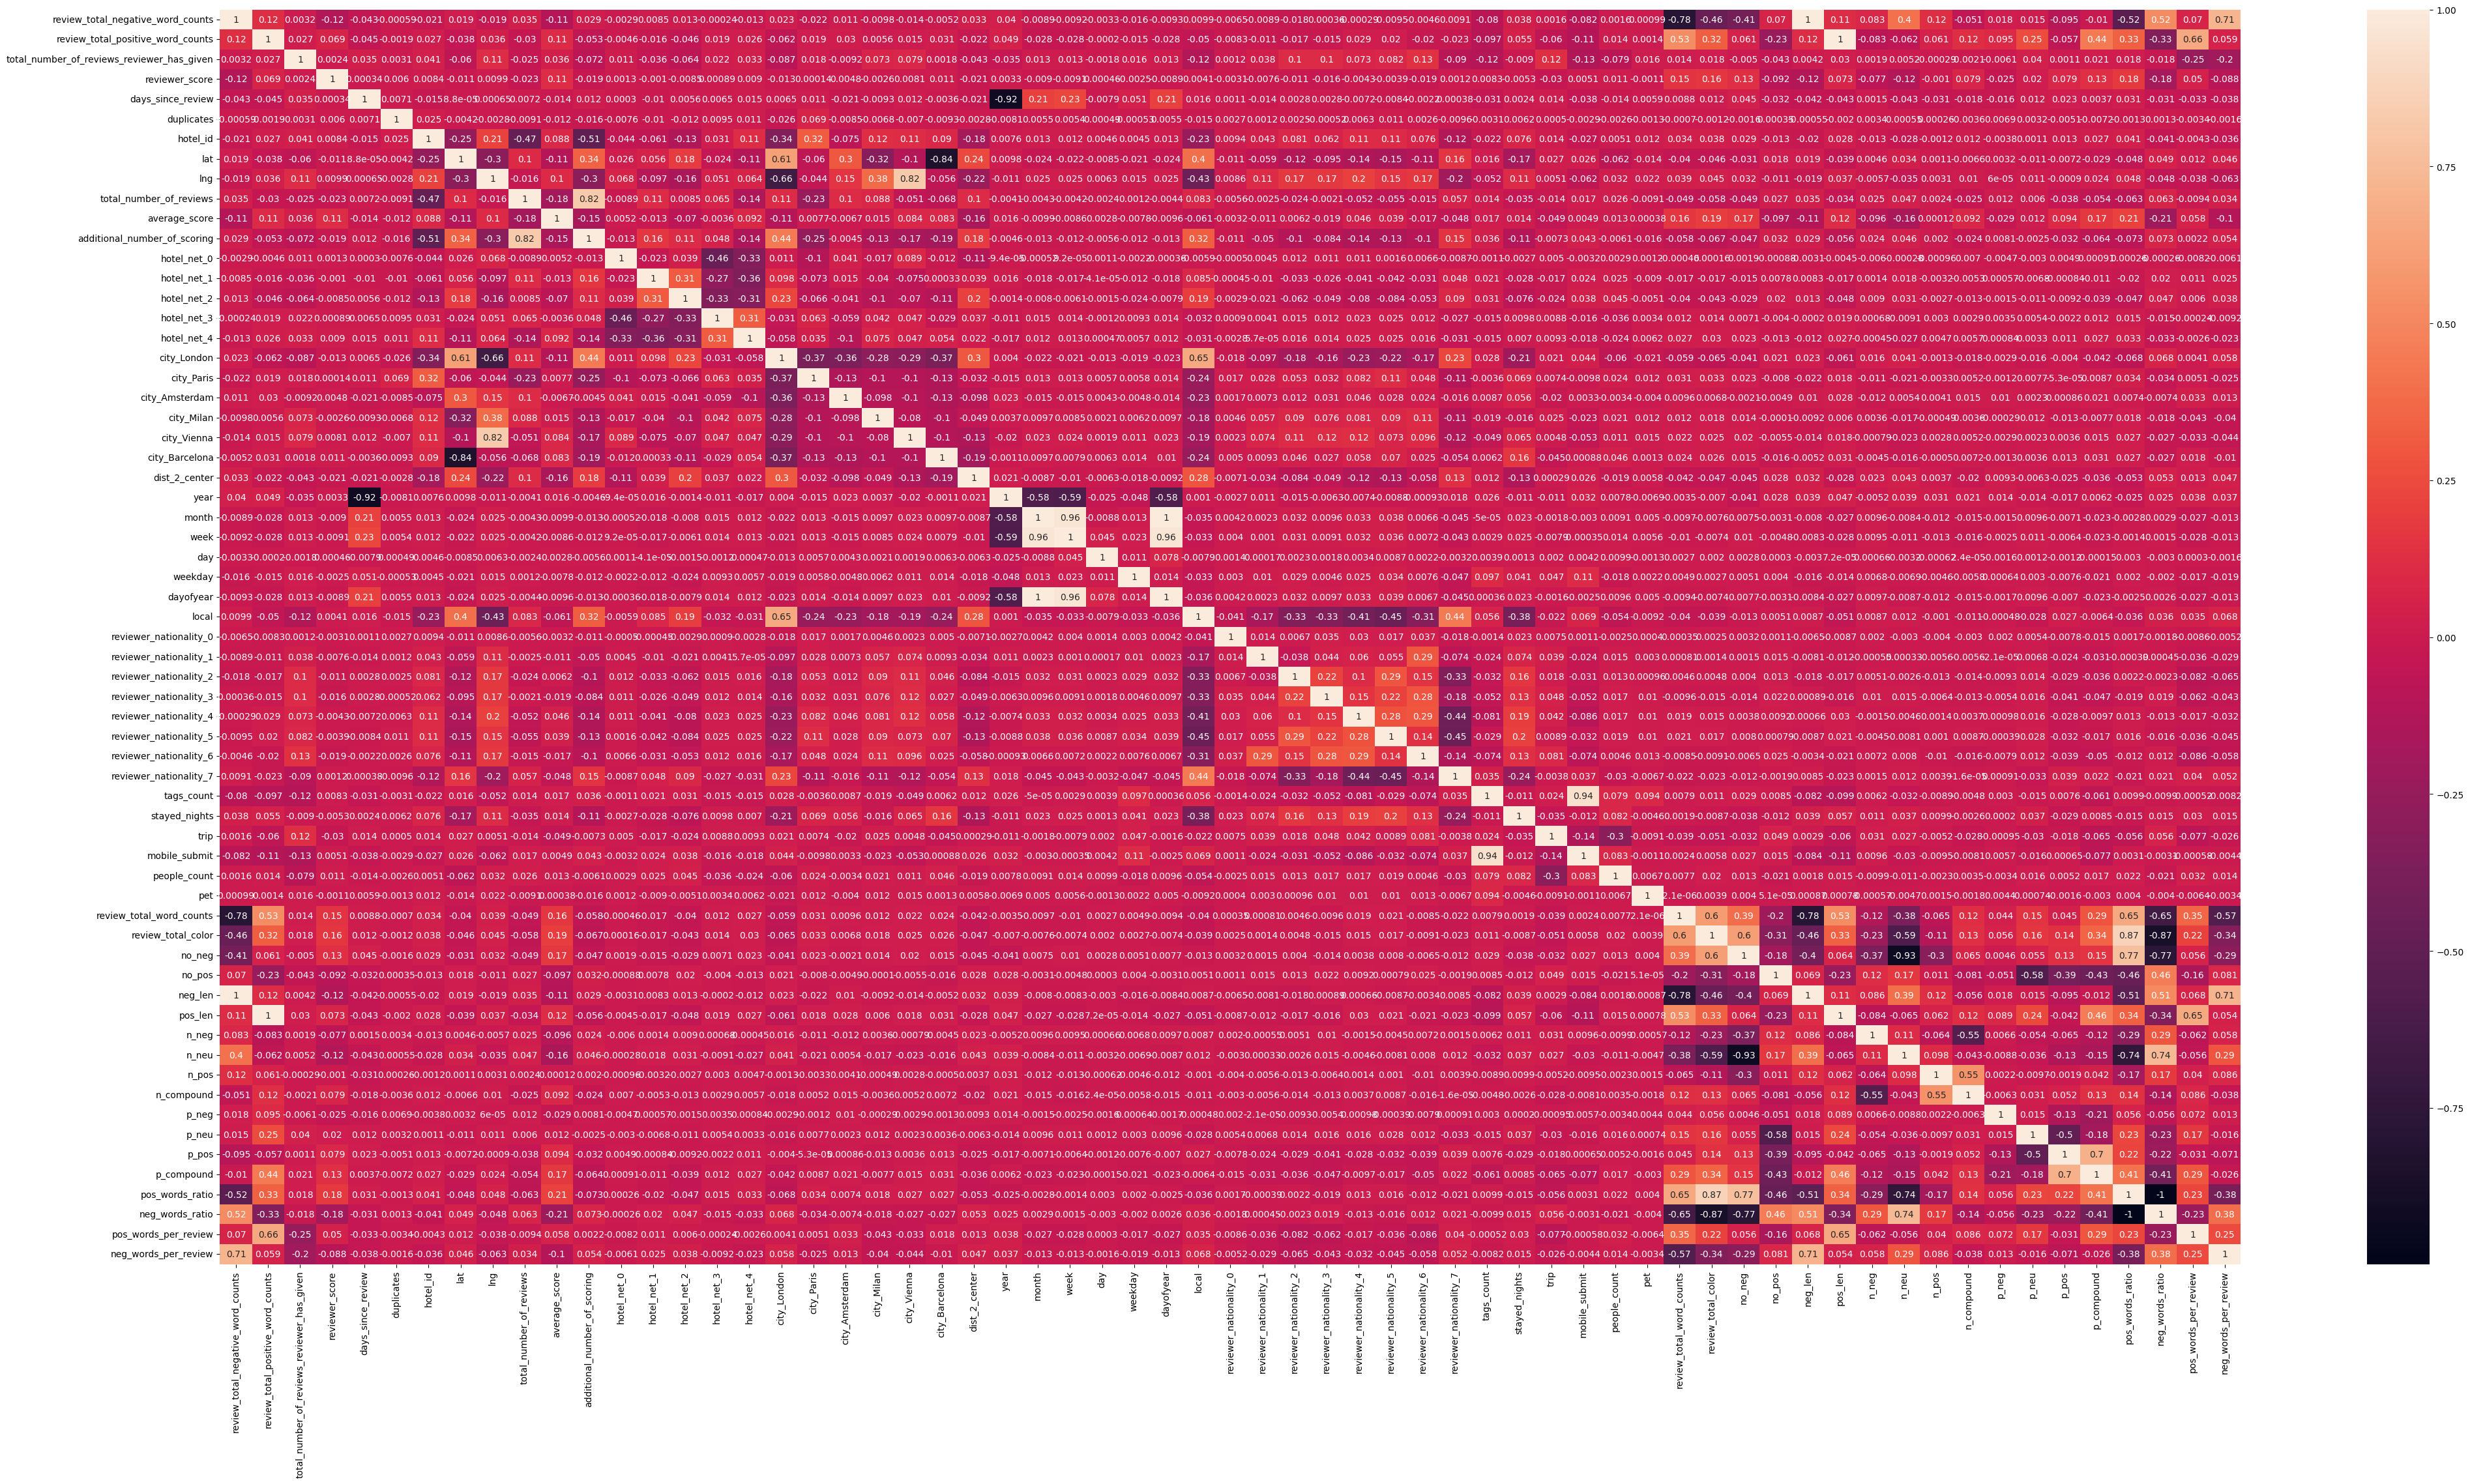

In [92]:
# Построим матрицу корреляции:
plt.rcParams['figure.figsize'] = (50, 25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True);

In [93]:
# Удалим признаки с высокой корреляцией:
data.drop(['year'], axis=1, inplace=True)
# удаление приводит к ухудшению предсказаний.

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   review_total_negative_word_counts           515738 non-null  int64         
 2   review_total_positive_word_counts           515738 non-null  int64         
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 4   reviewer_score                              515738 non-null  float64       
 5   days_since_review                           515738 non-null  int32         
 6   sample                                      515738 non-null  int64         
 7   duplicates                                  515738 non-null  int32         
 8   hotel_id                                    515738 non-null  int64        

In [95]:
# Удаляем признак даты:
data.drop(['review_date'], axis=1, inplace=True)

---
### Обучаем модель и делаем предсказание рейтинга отеля:

In [96]:
# Фиксируем RANDOM_SEED для воспроизводимости экспериментов:
RANDOM_SEED = 42

In [97]:
# Выделим тестовую часть:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [98]:
# Разделим тренировочные данные с помощью train_test_split:
# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

In [99]:
# Проверяем размерность выборок:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 62), (386803, 62), (386803, 61), (309442, 61), (77361, 61))

In [103]:
# Инициализируем модель:
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED
)

In [104]:
# Обучаем модель на тренировочные выборке:
model.fit(X_train, y_train)

# Предсказываем рейтинги отелей в тестовой выборке:
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


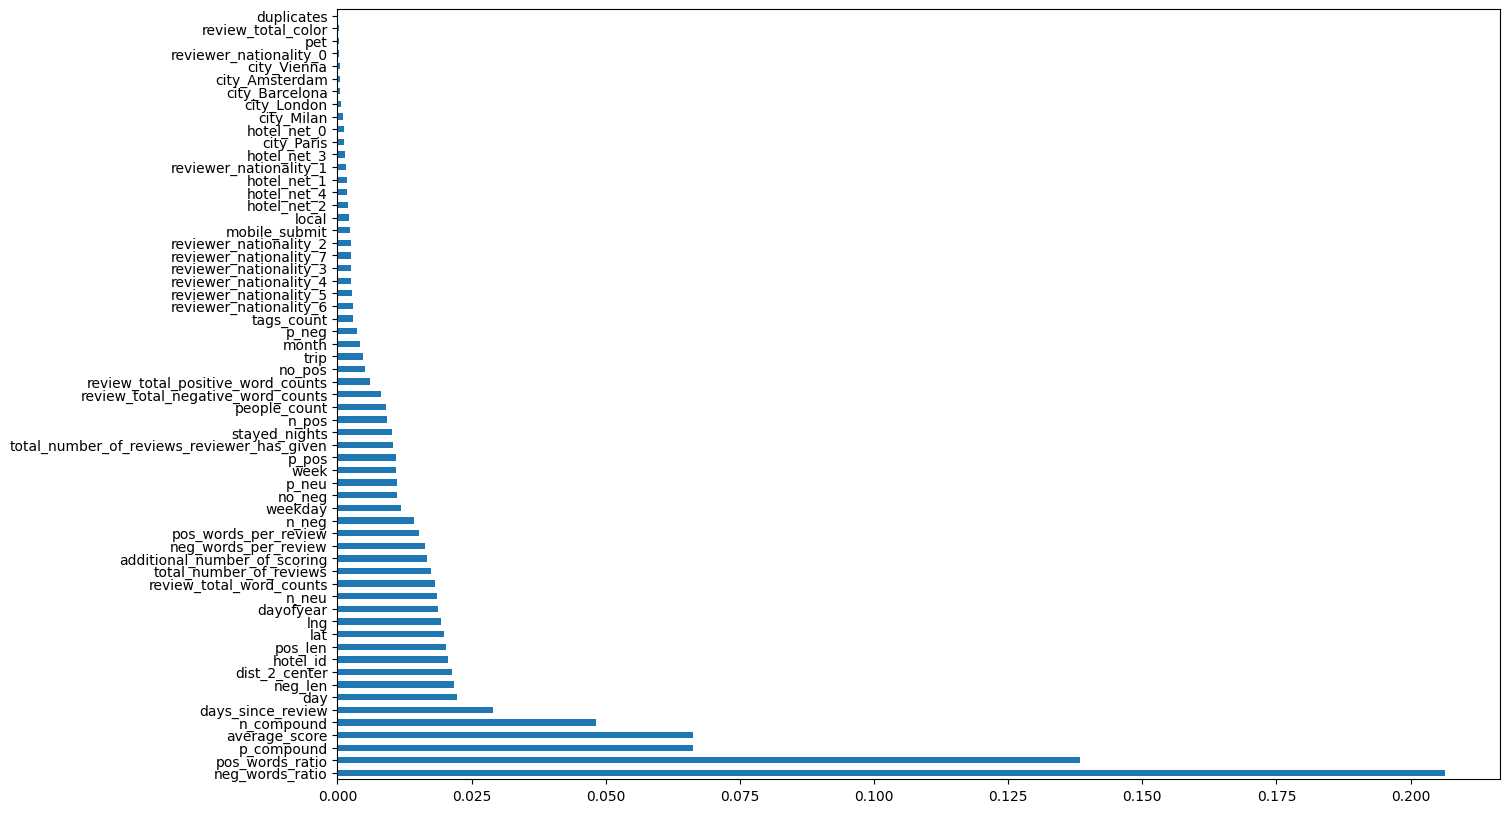

In [105]:
# Выводим самые важные признаки для модели:
plt.rcParams['figure.figsize'] = (15,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(70).plot(kind='barh');

---
### Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим среднюю абсолютную ошибку:
- *Mean Absolute Percentage Error (MAPE) показывает среднее отклонение в процентах предсказанных значений от фактических.*

- *Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических.*

In [108]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Выводим значение MAPE:
print('MAPE:', mape(y_test, y_pred))

MAPE: 12.268344099275037


In [109]:
# Выводим значение MAE:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.862449554685177


---
### Submission:

In [110]:
# Смотрим случайную выборку из данных:
test_data.sample(10)

review_total_negative_word_counts  review_total_positive_word_counts  \
396135                                 33                                 12   
432574                                 16                                  9   
515173                                 22                                 53   
392969                                 15                                 57   
469086                                 20                                 11   
514838                                 26                                  3   
463080                                 46                                  0   
513361                                 45                                 25   
494000                                  6                                  8   
412370                                 10                                 21   

        total_number_of_reviews_reviewer_has_given  reviewer_score  \
396135                                           1             0.0   
432574                                          16             0.0   
515173                                           9             0.0   
392969                                           9             0.0   
469086                                           6             0.0   
514838                                           5             0.0   
463080                                           1             0.0   
513361                                           4             0.0   
494000                                           1             0.0   
412370                                           1             0.0   

        days_since_review  duplicates  hotel_id        lat       lng  \
396135                604           0       650  41.384829  2.175128   
432574                565           0       604  51.514707 -0.157829   
515173                293           0       133  52.366373  4.893051   
392969                120           0       174  51.510237 -0.076443   
469086                 81           0       567  48.896985  2.385274   
514838                440           0       345  45.461177  9.191047   
463080                 31           0       364  51.521012 -0.262862   
513361                467           0         8  51.500198 -0.179536   
494000                359           0       151  51.474469 -0.019428   
412370                 73           0       205  51.519569 -0.170521   

        total_number_of_reviews  ...  n_pos  n_compound  p_neg  p_neu  p_pos  \
396135                     2695  ...  0.077     -0.3832  0.000  0.429  0.571   
432574                     1330  ...  0.161      0.3182  0.000  1.000  0.000   
515173                     4231  ...  0.098     -0.2315  0.039  0.690  0.271   
392969                     4672  ...  0.182      0.4404  0.000  0.589  0.411   
469086                     2740  ...  0.080     -0.4201  0.000  0.331  0.669   
514838                     3720  ...  0.096      0.0000  0.000  0.256  0.744   
463080                     1500  ...  0.123      0.5574  0.000  0.000  0.000   
513361                      968  ...  0.055     -0.1531  0.000  0.549  0.451   
494000                     1805  ...  0.000     -0.2960  0.000  0.682  0.318   
412370                     6977  ...  0.000      0.0000  0.064  0.685  0.251   

        p_compound  pos_words_ratio  neg_words_ratio  pos_words_per_review  \
396135      0.8923         0.266667         0.733333             12.000000   
432574      0.0000         0.360000         0.640000              0.562500   
515173      0.9383         0.706667         0.293333              5.888889   
392969      0.9811         0.791667         0.208333              6.333333   
469086      0.9022         0.354839         0.645161              1.833333   
514838      0.4404         0.103448         0.896552              0.600000   
463080      0.0000         0.000000         1.000000              0.000000   
513361      0.9295         0.357143         0.642857      

In [111]:
# Удаляем целевой признак из тестовой выборки:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [112]:
# Сохраняем предсказание модели в сабмишн:
submission['reviewer_score'] = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.5s finished


In [113]:
# Сохраняем сабмишн в csv-файл:
submission.to_csv('submission.csv', index=False)
submission.head()

reviewer_score      id
0           8.767  488440
1           7.542  274649
2           7.953  374688
3           9.772  404352
4           9.509  451596